<p style="color:navy; font-weight:bold; font-family:newtimesroman; font-size:200%; text-align:center">PRONÓSTICO: SERIE DE TIEMPO AIRLINE PASSENGERS</p>
<br>

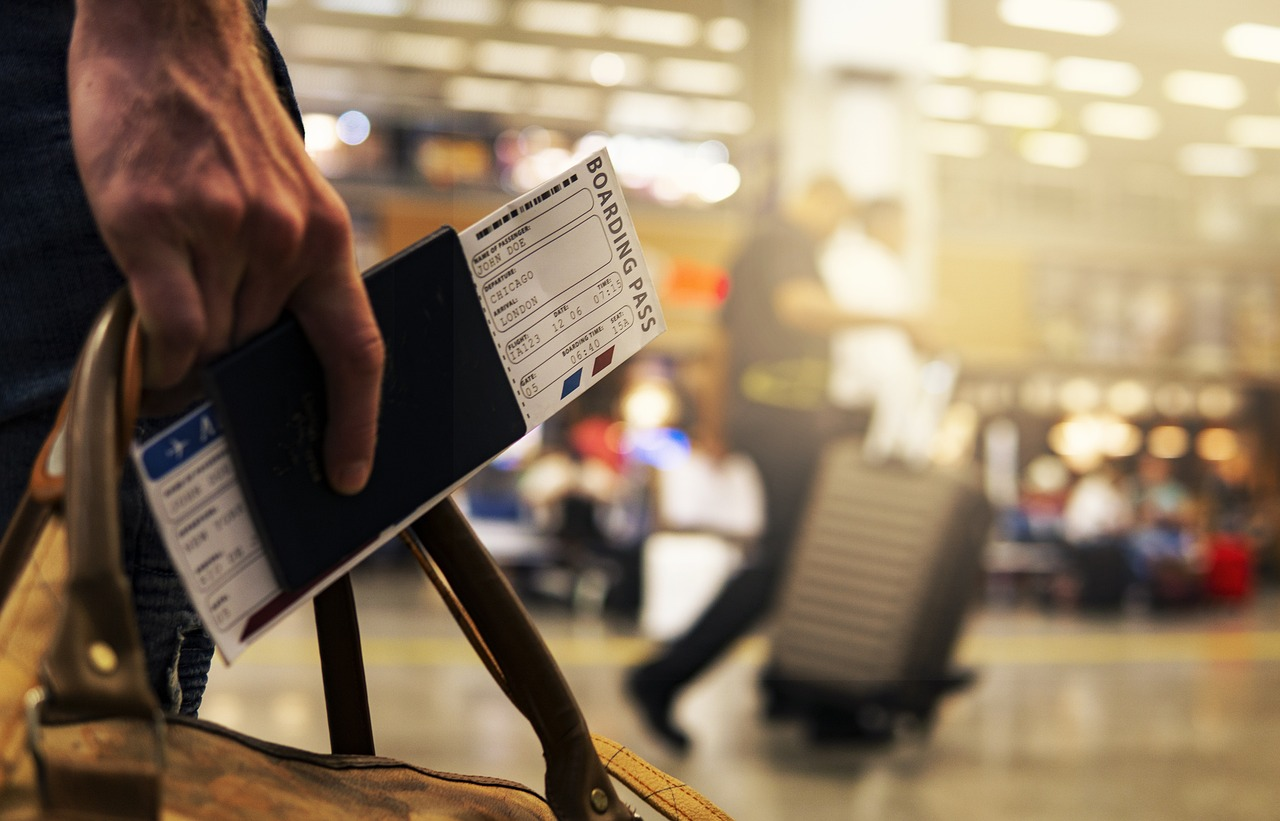

# Introducción <a class="tocSkip">

<div class=text-justify>
En todas las empresas es necesario hacer pronósticos, ya sea para conocer el número de clientes potenciales, la cantidad de operaciones que se alcanzarán el siguiente año, la cantidad de ingresos que se esperan obtener derivado de las estratégias implementadas, etc. Por lo tanto, es básico conocer y saber hacer este tipo de modelos.
</div>
<br>
<div class=text-justify>
El presente proyecto consiste en analizar una serie de tiempo y realizar el correspondiente pronóstico. Se aprovecha este tipo de series para paracticar la imputación de valores faltantes así como el tratamiento de los llamados outliers. Para hacer los pronósticos se utiliza el modelo <strong>ARIMA (AutoRegressive Integrated Moving Average)</strong>. La métrica de evaluación es el <strong>error porcentual absoluto medio (mape)</strong>, sin embargo, se generarán más metricas con fines comparativos. Además, a cada modelo se le analizarán sus residuales. Finalmente, para el modelo finalista se evaluarán los supuestos de <strong>normalidad, heterocedasticidad</strong> y <strong>autocorrelación</strong>.
</div>

# Set up

Primero, importamos los principales paquetes que se usarán lo largo del proyecto.

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt

import matplotlib

%matplotlib inline

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns
sns.set(rc = {'figure.figsize':(16,5)})

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Importar data

<div class=text-justify>
Los datos que se usarán corresponden al clásico dataset <strong>airline_passengers</strong>, que contiene el número mensual de pasajeros de una aerolinea de los Estados Unidos entre 1949 y 1960. Este conjunto de datos es muy usado para practicar el tratamiento y elaboración de pronósticos a series de tiempo. Hay que aclarar que se hicieron algunas modificaciones al dataset original con el objetivo de practicar la imputación y el tratamiento de datos.
</div>

In [2]:
df = pd.read_csv('data/airline_passengers_toy.csv')
df.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


Por comodidad se cambian los nombres a las variables.

In [3]:
df.rename(columns = {'Month':'date',
                     'Thousands of Passengers':'passengers'},
          inplace = True)
df.head()

,date,passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


# EDA

En esta parte se hrá el análisis exploratorio de los datos, **EDA** (por sus siglas en Inglés).

Se inicia checando el tipo de cada variable y sus dimensiones.

In [4]:
df.dtypes

date           object
passengers    float64
dtype: object

In [5]:
print('Total de filas: {}\nTotal de columnas: {}'.format(df.shape[0], df.shape[1]))

Total de filas: 144
Total de columnas: 2


<div class=text-justify>
Una de las primeras acciones que se tiene que hacer cuando se trabaja con bases de datos es conocer si en ella existen valores faltantes o nulos y más si la tarea será tratar esos datos como una serie de tiempo. Además, algunas funciones y algoritmos no funcionan si los datos presentan observaciones faltantes.
</div>

In [6]:
def summary_nulls(df):
    
    missing_columns = pd.DataFrame()
    total = df.shape[0]
    
    missing_columns['Variable'] = [col for col in df.columns if df[col].isnull().sum() > 0]
    columns_nulls = missing_columns['Variable'].to_numpy()   
    
    missing_columns['Nulls'] = [df[col].isnull().sum() for col in columns_nulls]
    missing_columns['Percentage'] = missing_columns['Nulls'].apply(lambda x: round((x / total) * 100, 3))
    
    missing_columns.sort_values(by = 'Percentage', ascending = False)
    
    return missing_columns

In [7]:
summary_nulls(df)

,Variable,Nulls,Percentage
0,passengers,2,1.389


<div class=text-justify>
En el conjunto de datos solo hay 2 observaciones faltantes que representan el 1.39%. Para cambiar la forma en que se detectan los valores faltantes se crea una gráfica tipo heatmap. Lo anterior, no es necesario, sin embargo, visualmente es más fácil de ver en dónde se presenta este problema. Es como hacer una radiografía a la base de datos, pues no importa si ésta consta de una o 10 variables.
</div>

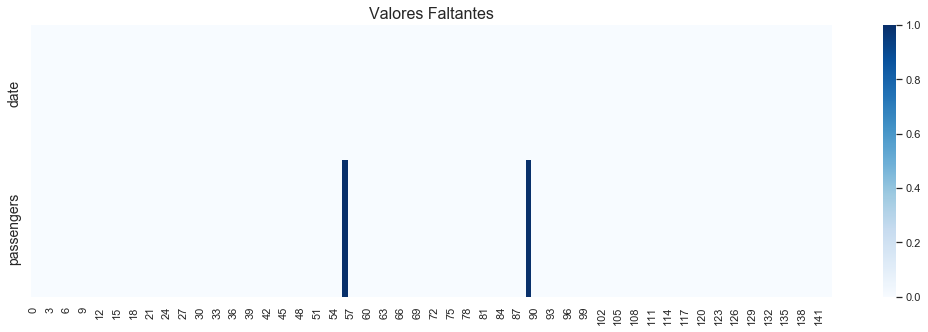

In [8]:
f, ax = plt.subplots(figsize = (16, 5))

sns.heatmap(df.T.isna(), cmap = 'Blues')
ax.set_title('Valores Faltantes', fontsize = 16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.show()

Se grafica la serie para ver en dónde están esas 2 observaciones que faltan.

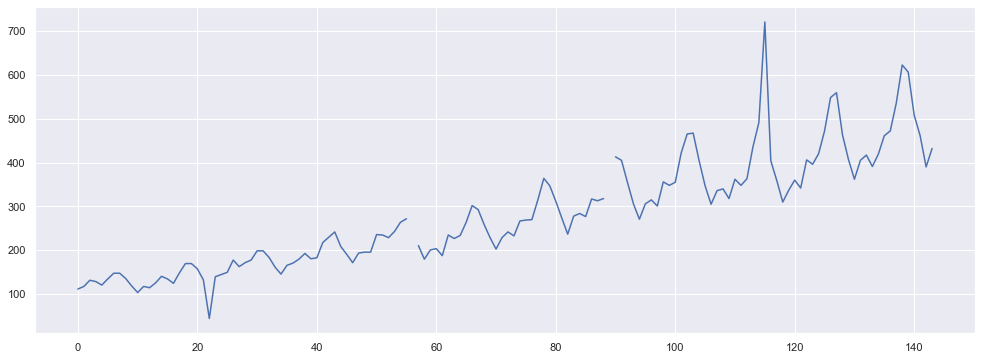

In [9]:
df.passengers.plot(figsize = (15,6));

<div class=text-justify>
Como es una serie de tiempo no podemos imputar esos datos con la media o mediana de toda la serie, ya que se aprecia que los datos tienen tendencia positiva, por lo que, la estratégia a seguir será la imputación por interpolación. Pero primero veamos, con apoyo de una gráfica de linea, como quedaría la serie antes de hacer la imputación.
</div>

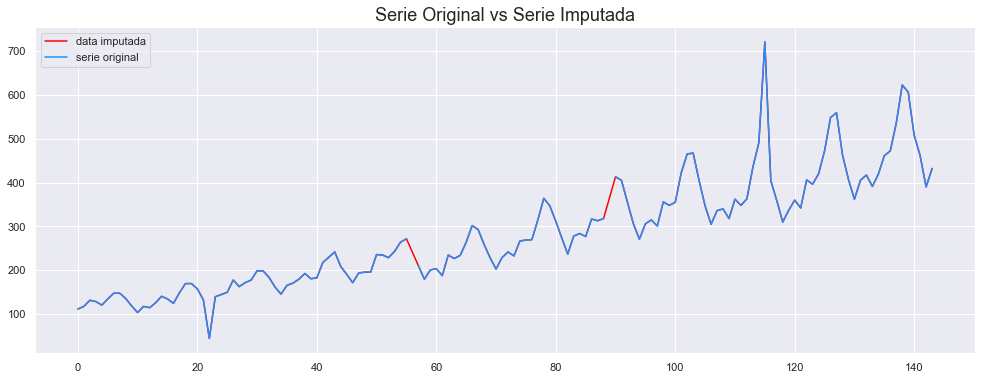

In [10]:
df.passengers.interpolate().plot(figsize = (15,6), color = 'red', label = 'data imputada')
df.passengers.plot(figsize = (15,6), color = 'dodgerblue', label = 'serie original')
plt.title('Serie Original vs Serie Imputada', fontdict = {'fontsize':18})
plt.legend(loc = 'upper left');

Al parecer la imputación por interpolación se ajusta bien a la serie original, ya que respeta el patrón de los datos. Por lo anterior, se procede a realizar esta corrección.

In [11]:
df['passengers'] = df['passengers'].interpolate()
df.isna().sum()

date          0
passengers    0
dtype: int64

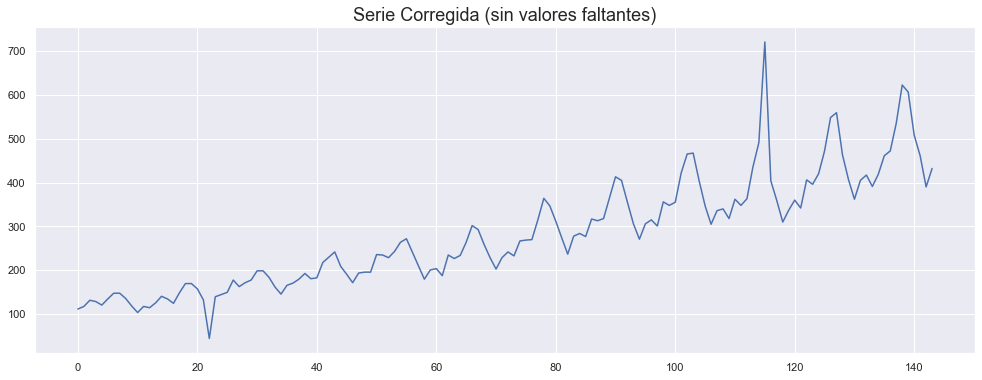

In [12]:
df.passengers.plot(figsize = (15,6))
plt.title('Serie Corregida (sin valores faltantes)', fontdict = {'fontsize':18});

<div class=text-justify>
Al inicio se detecto que el tipo de dato de la variable "passengers" es de tipo float, el cual es incorrecto, ya que los datos corresponden al número de pasajeros, por lo que, no deben contener decimales. Además, la variable "date" esta como tipo object y debe ser una fecha. Así que, se procede a corregir esos tipos.
</div>

In [13]:
df.passengers = df.passengers.astype('int')
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m')

df.dtypes

date          datetime64[ns]
passengers             int32
dtype: object

In [14]:
print('Fecha inicial: {}\nFecha final: {}'.format(df.date.min(), df.date.max()))

Fecha inicial: 1949-01-01 00:00:00
Fecha final: 1960-12-01 00:00:00


Se tiene una serie de tiempo que abarca el periodo desde enero de 1941 hasta diciembre de 1960.

La variable date no está como índice, por lo que, se debe configurar para que este como tal y se almacena en otro objeto para trabajar sobre él.

In [15]:
y = df.set_index('date')
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='date', length=144, freq=None)

Ahora, hay que incorporar el tipo de frecuencia a la serie, porque actualmente esta como **None**. Como la frecuencia es mensual, se configura como **'MS'**.

In [16]:
y.index = pd.DatetimeIndex(y.index, freq = 'MS')
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='date', length=144, freq='MS')

Ya solo falta hacer una validación para confirmar que la serie esta regularizada, o sea, que no faltan fechas en el periodo de tiempo a trabajar.

In [17]:
(y.index == pd.date_range(start = y.index.min(),
                         end = y.index.max(),
                         freq = y.index.freq)).all()

True

Se grafica la data ya como una serie de tiempo bien configurada.

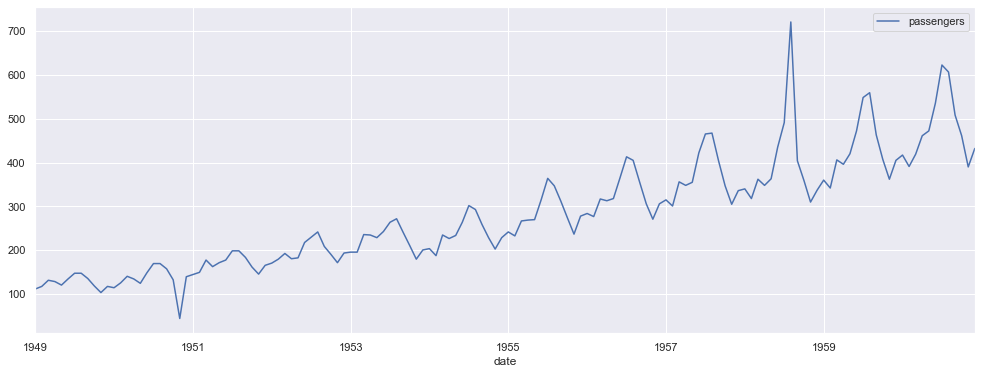

In [18]:
y.plot(figsize = (15,6));

## Valores atípicos

<div class=text-justify>
Existen diferentes técnicas para detectar observaciones atípicas mejor conocidas como outliers, sin embargo, cuando se trabaja con series de tiempo hay que ir con cuidado y más si la serie presenta tendencia creciente elevada. Aquí se decidió utilizar el <strong>Hampel Filter</strong> que, básicamente, consiste en que a cada valor de la serie se calcula la mediana a una ventana de tiempo (un subconjunto de valores circundantes a dicha observación), luego se estima la desviación estándar utilizando la medida llamada "mediana de la desviación absoluta con respecto a la mediana", que también se conoce como <strong>MAD (Median Absolute Deviation).</strong>
</div>
<br>
La idea es que si una muestra difiere de la mediana en más de k desviaciones estándar, se considera un dato atípico y se reemplaza por el valor de la mediana.

La siguiente función calcula dicho filtro basada en el paquete `pracma` de r.

In [19]:
def hampel_filter_forloop(time_series, window_size, n_sigmas = 3):
    
    n = len(time_series)
    new_series = time_series.copy()
    k = 1.4826
    
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.median(time_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(time_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(time_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [20]:
# el input debe ser un objeto Series

x = df['passengers']
x

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: passengers, Length: 144, dtype: int32

In [21]:
# se utilizan window_size = 2 (asemejando una interpolacion lineal)

resultado, atipicos = hampel_filter_forloop(x, 2)

In [22]:
atipicos

[22, 115]

El filtro encontró 2 observaciones atípicas en las posiciones 22 y 115. Veamos cómo quedaría la serie.

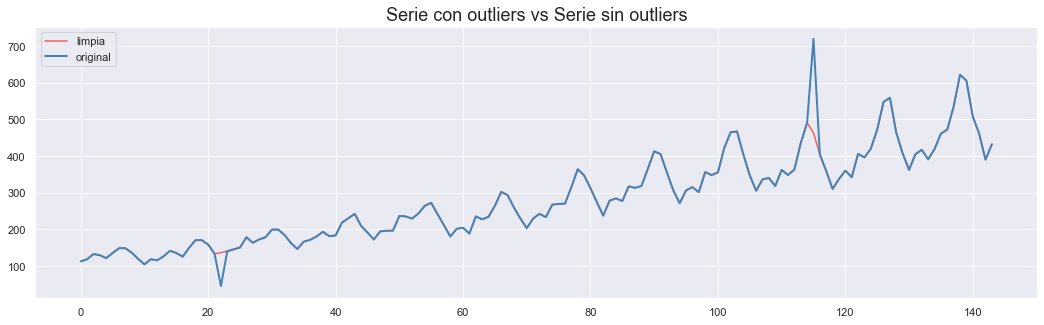

In [23]:
plt.plot(np.arange(len(resultado)), resultado, color = 'red', label = 'limpia', alpha = 0.6)
plt.plot(np.arange(len(df)), df.passengers, color = 'steelblue', label = 'original', lw = 2)
plt.title('Serie con outliers vs Serie sin outliers', fontdict = {'fontsize':18})
plt.legend(loc = 'upper left');

Agregamos y limpiamos la nueva serie llamada **"resultado"** sin las 2 observaciones atípicas.

In [24]:
df['passengers_clean'] = resultado
df

,date,passengers,passengers_clean
0,1949-01-01,112,112
1,1949-02-01,118,118
2,1949-03-01,132,132
3,1949-04-01,129,129
4,1949-05-01,121,121
...,...,...,...
139,1960-08-01,606,606
140,1960-09-01,508,508
141,1960-10-01,461,461
142,1960-11-01,390,390


In [25]:
df.drop(columns = 'passengers', inplace = True)
df

,date,passengers_clean
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [26]:
df.set_index('date', inplace = True)
df

,passengers_clean
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


La serie ya está limpia y lista para empezar formalmemte el análisis estadístico de esta serie de tiempo.

# Detectando estacionariedad

<div class=text-justify>
La estacionariedad se refiere a que los datos de series de tiempo tienen una media y varianza que no cambian en el tiempo, son constantes, en cambio, si presentan tendencia, ya sea creciente o decreciente y, además, estacionalidad, o sea, patrones repetitivos y reconocibles dentro de un año, entonces se dice que la serie no es estacionaria y no se debe utilizar así para realizar pronósticos.
</div>
<br>
El análisis inicial para identificar visualmente si una serie presenta tendencia es graficar las observaciones contra el tiempo.

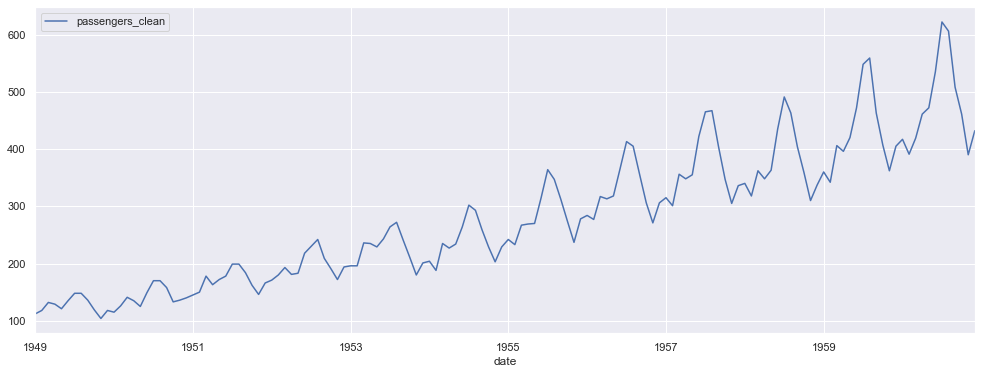

In [27]:
df.plot(figsize = (15,6));

Se puede apreciar claramente en la gráfica anterior que la serie presenta tendencia creciente y multiplicativa y, también, estacionalidad, por lo que, su media y varianza no son constantes a lo largo del periodo.

Vamos a calcular ventanas móviles de 12 meses tanto para la media y la adesviación estándar, para conocer su tendencia.

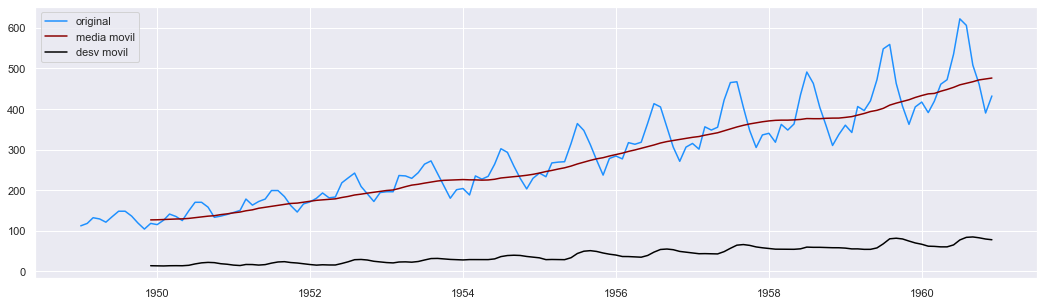

In [28]:
rol_mean = df.rolling(12).mean()
rol_std = df.rolling(12).std()

origin = plt.plot(df, color = 'dodgerblue', label = 'original')
mean = plt.plot(rol_mean, color = 'darkred', label = 'media movil')
std = plt.plot(rol_std, color = 'black', label = 'desv movil')

plt.legend(loc = 'best')
plt.show(block = False)

En la grafica se ve cómo la media no es constante a lo largo del tiempo. La desviación estándar presenta una ligera tendencia positiva.

## Descomposición de la serie

A continuación, se va a descomponer la serie de tiempo para poder apreciar mejor sus distintos componentes: la tendencia, la estacionalidad y el componente residual.

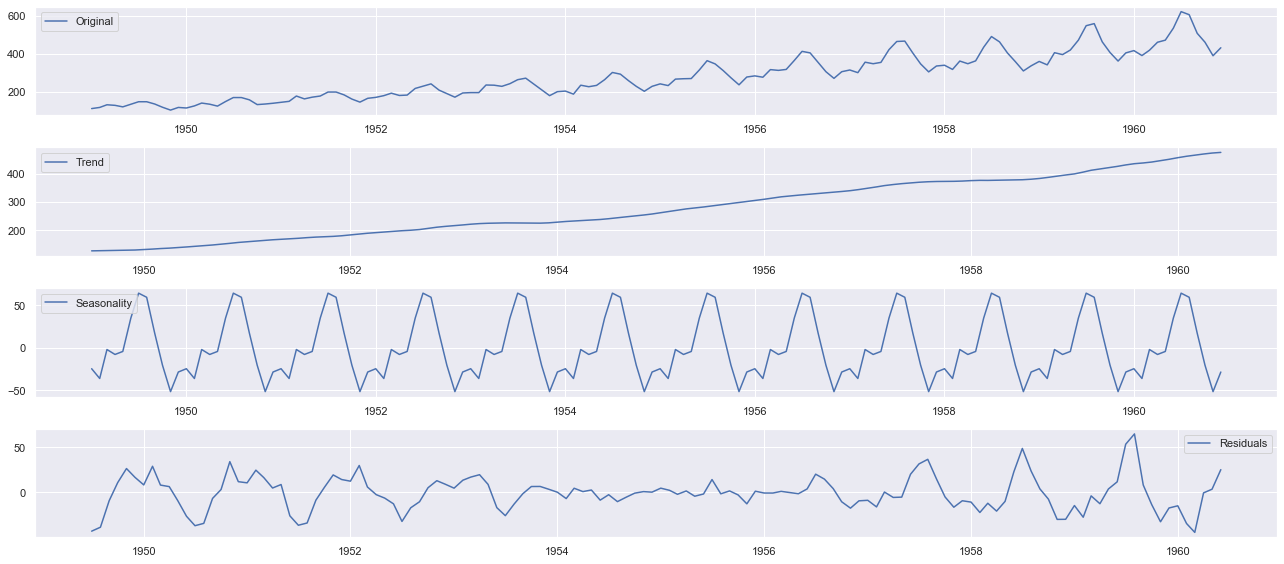

In [29]:
descomposicion = seasonal_decompose(df)

trend = descomposicion.trend
seasonal = descomposicion.seasonal
residual = descomposicion.resid

plt.subplots(figsize = (18, 8))

plt.subplot(411)
plt.plot(df, label = 'Original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')

plt.tight_layout()

En estas gráficas se ve por separado cada componente de la serie de tiempo. Se aprecia la tendencia creciente, la estacionalidad muy marcada y el componente residual.

Veamos ahora otra opción para detectar la existencia de estacionariedad en las series de tiempo: los **correlogramas.**

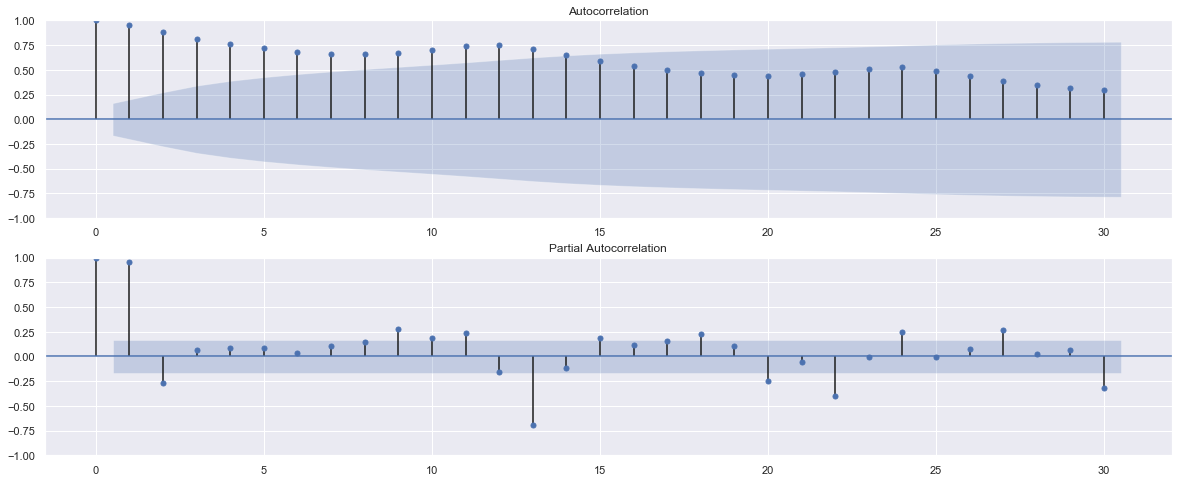

In [30]:
plt.figure(figsize = (18,8))

plt.subplot(211)
plot_acf(df.passengers_clean, ax = plt.gca(), lags = 30)

plt.subplot(212)
plot_pacf(df.passengers_clean, ax = plt.gca(), lags = 30);

El primer correlograma nos indica que la serie es no estacionaria (en niveles), ya que los coeficientes de autocorrelación decaen muy lentamente hacia el cero, lo cual es un indicativo de la afirmación anterior.

Un enfoque estadístico para detectar y confirmar que una serie de tiempo es o no estacionaria es a través de la prueba conocida **Dickey-Fuller Aumentada**. Prueba la hipótesis nula de que una raíz unitaria está presente en nuestra serie temporal. La hipótesis nula es que la serie no es estacionaria.

In [31]:
def test_stationarity(time_series, autolag = 'AIC'):

    print('Resultado de la prueba Dickey-Fuller: \n')

    dftest = adfuller(time_series, autolag = autolag)
    dfoutput = pd.Series(dftest[0:4], index = ['Test statistic', 'p-vaue', '#Lags', 'No. Obs.'])

    for key, value in dftest[4].items():
        dfoutput['Valor critico (%s)'%key] = value

    print(dfoutput,'\n')

    if dfoutput[1] < 0.05:
        print('El p-value es menor a 0.05, por tanto, la serie es Estacionaria')
    else:
        print('El p-value es mayor a 0.05, por tanto, la serie No es Estacionaria')

In [32]:
test_stationarity(df.passengers_clean)

Resultado de la prueba Dickey-Fuller: 

Test statistic           0.800329
p-vaue                   0.991641
#Lags                   13.000000
No. Obs.               130.000000
Valor critico (1%)      -3.481682
Valor critico (5%)      -2.884042
Valor critico (10%)     -2.578770
dtype: float64 

El p-value es mayor a 0.05, por tanto, la serie No es Estacionaria


<div class=text-justify>
Ya comprobamos que la serie <strong>no es estacionaria</strong>, por lo tanto, para hacer que nuestros datos sean estacionarios, vamos a diferenciarlos una vez. Esto consiste en calcular las diferencias entre observaciones consecutivas. La diferenciación puede ayudar a estabilizar la media de una serie temporal al eliminar los cambios en el nivel de ésta y, por lo tanto, eliminar (o reducir) la tendencia y la estacionalidad.
</div>

In [33]:
df_dif = (df - df.shift(1)).dropna()

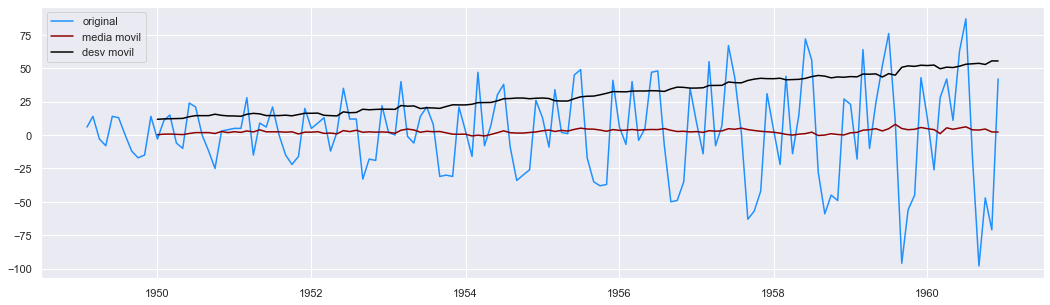

In [34]:
rol_mean = df_dif.rolling(12).mean()
rol_std = df_dif.rolling(12).std()

origin = plt.plot(df_dif, color = 'dodgerblue', label = 'original')
mean = plt.plot(rol_mean, color = 'darkred', label = 'media movil')
std = plt.plot(rol_std, color = 'black', label = 'desv movil')

plt.legend(loc = 'best')
plt.show(block = False)

Volvemos a realizar la prueba Dickey-Fuller Aumentada

In [35]:
test_stationarity(df_dif.passengers_clean)

Resultado de la prueba Dickey-Fuller: 

Test statistic          -2.904723
p-vaue                   0.044802
#Lags                   12.000000
No. Obs.               130.000000
Valor critico (1%)      -3.481682
Valor critico (5%)      -2.884042
Valor critico (10%)     -2.578770
dtype: float64 

El p-value es menor a 0.05, por tanto, la serie es Estacionaria


Aplicando primeras diferencias la serie ya **es estacionaria**. Por lo tanto, ya se puede modelar para hacer nuestro pronóstico.

Sin embargo, se aplicará una transformacion logarítmica para estabilizar la varianza esperando mejorar un poco más el p-valor debido a que la serie presenta varianza creciente a lo largo del tiempo.

In [36]:
df_log = np.log(df)

moving_avg = df_log.rolling(window = 12).mean()
moving_std = df_log.rolling(window = 12).std()

moving_avg_f = df_log - moving_avg
moving_avg_f.dropna(inplace = True)

moving_avg_f.head()

,passengers_clean
date,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


In [37]:
test_stationarity(moving_avg_f.passengers_clean)

Resultado de la prueba Dickey-Fuller: 

Test statistic          -3.327413
p-vaue                   0.013697
#Lags                   13.000000
No. Obs.               119.000000
Valor critico (1%)      -3.486535
Valor critico (5%)      -2.886151
Valor critico (10%)     -2.579896
dtype: float64 

El p-value es menor a 0.05, por tanto, la serie es Estacionaria


Vemos que al aplicar la transformación logarítmica mejoró el p-valor de la prueba, por lo que, tomaremos esta última serie, ya que además, podremos volver a la escala original sin dificultad.

# Estacionalidad y tendencia

En esta parte vamos se van a revisar los componentes de tendencia y estacionalidad. Para lo anterior, se hará un análisis visual a la serie, pues es la mejor forma de identificarlos.

<Figure size 1152x576 with 0 Axes>

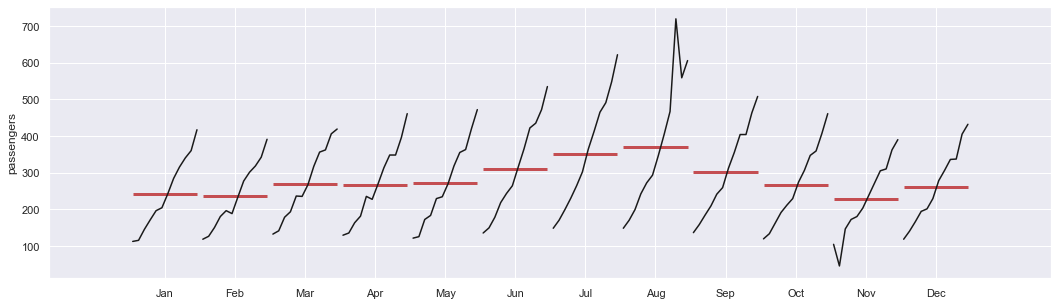

In [38]:
plt.figure(figsize = (16, 8))

month_plot(y['passengers'], ylabel = 'passengers');

En la gráfica anterior, se aprecia como es el comportamiento de la serie a lo largo de los meses. En el mes de agosto se presentan los niveles de afluencia mayores y, por el contrario, en noviembre se presenta el nivel más bajo de pasajeros.

Veamos otros gráficos complementarios.

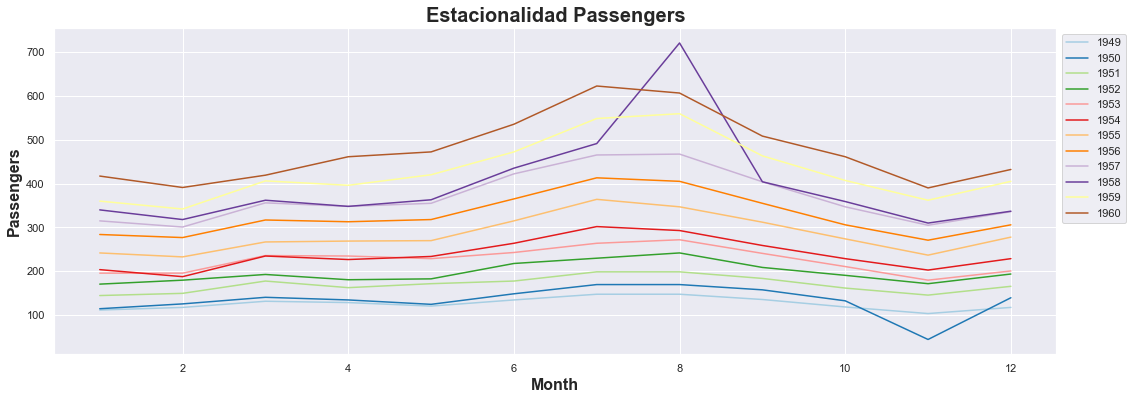

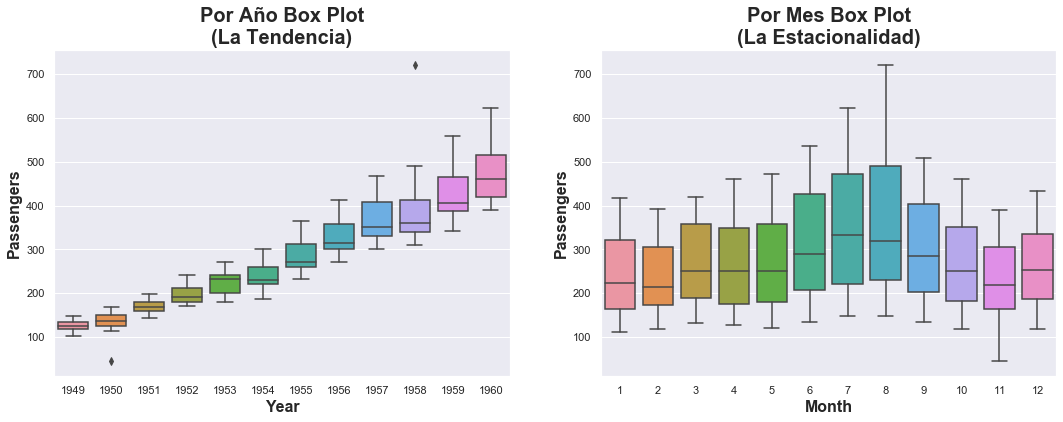

In [39]:
f, ax = plt.subplots(figsize = (16, 6))

palette = sns.color_palette("Paired")

y['month'] = y.index.month
y['year'] = y.index.year

sns.lineplot(y['month'], y['passengers'], hue = y['year'], palette = palette)
ax.set_title('Estacionalidad Passengers', fontsize = 20, loc = 'center', fontdict = dict(weight = 'bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict = dict(weight = 'bold'))
ax.set_ylabel('Passengers', fontsize = 16, fontdict = dict(weight = 'bold'))
ax.legend(bbox_to_anchor = (1, 1))

f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

sns.boxplot(y['year'], y['passengers'], ax = ax[0])
ax[0].set_title('Por Año Box Plot\n(La Tendencia)', fontsize = 20, loc = 'center', fontdict = dict(weight = 'bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict = dict(weight = 'bold'))
ax[0].set_ylabel('Passengers', fontsize = 16, fontdict = dict(weight = 'bold'))

sns.boxplot(y['month'], y['passengers'], ax = ax[1])
ax[1].set_title('Por Mes Box Plot\n(La Estacionalidad)', fontsize = 20, loc = 'center', fontdict = dict(weight = 'bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict = dict(weight = 'bold'))
ax[1].set_ylabel('Passengers', fontsize = 16, fontdict = dict(weight = 'bold'));

<div class=text-justify>
De las gráficas anteriores podemos intuir que la tendencia es multiplicativa, ya que en el boxplot de la tendencia se aprecia como cada año la mediana de los pasajeros va incrementandose. Además, con la primer gráfica podemos apreciar como en agosto de 1958 hay un incremento atípico, el cual hace que en el boxplot de la estacionalidad el bigote superior se alargue. Antes de pasar a revisar la tendencia, veamos los índices estacionales.
</div>

In [40]:
decomposition = sm.tsa.seasonal_decompose(y.passengers, model = 'multiplicative')

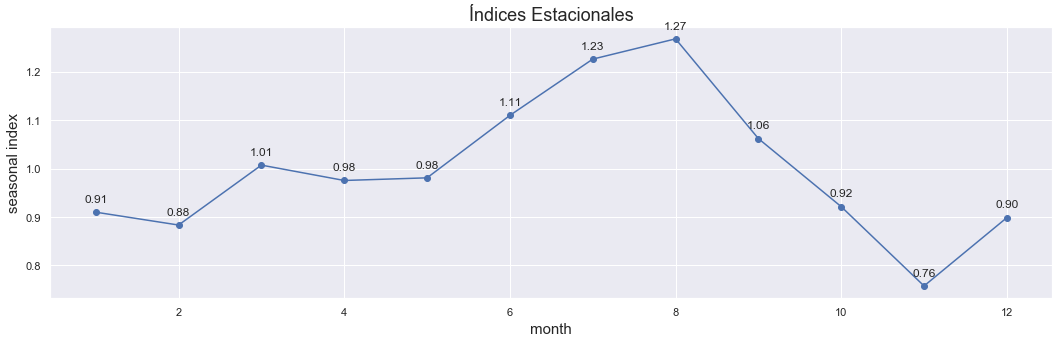

In [41]:
plt.clf()

ie = pd.DataFrame(decomposition.seasonal).head(12)
ie['month'] = ie.index.month
ie.set_index('month', inplace = True)

plt.plot(ie.index, ie.seasonal, 'bo-')
plt.title('Índices Estacionales', fontsize = 18)
plt.xlabel('month', fontsize = 15)
plt.ylabel('seasonal index', fontsize = 15);

for a, b in zip(ie.index, ie.seasonal):

    label = "{:.2f}".format(b)

    plt.annotate(label,
                 (a, b),
                 textcoords = "offset points",
                 xytext = (0, 10),
                 ha = 'center')

Veamos la fuerza de la estacionalidad: 0 significa un efecto bajo y 1 es un efecto alto:

In [42]:
max(0, (1 - decomposition.resid.var() / (decomposition.resid + decomposition.seasonal).var()))

0.7711747437716311

Ahora, la tendencia es multiplicativa, porque cada ciclo es mayor. Para ver lo anterior, se le quita el componente de tendencia a la serie.

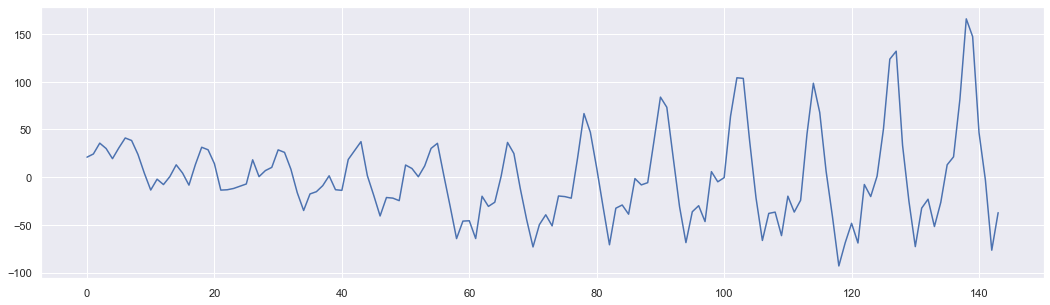

In [43]:
from scipy import signal

detrended = signal.detrend(df.reset_index()[['date', 'passengers_clean']]['passengers_clean'].values)
plt.plot(detrended);

El filtro Hodrick-Prescott separa una serie de tiempo en sus componentes de tencencia y ciclo. Para datos mensuales el valor de lamba es de 129,600.

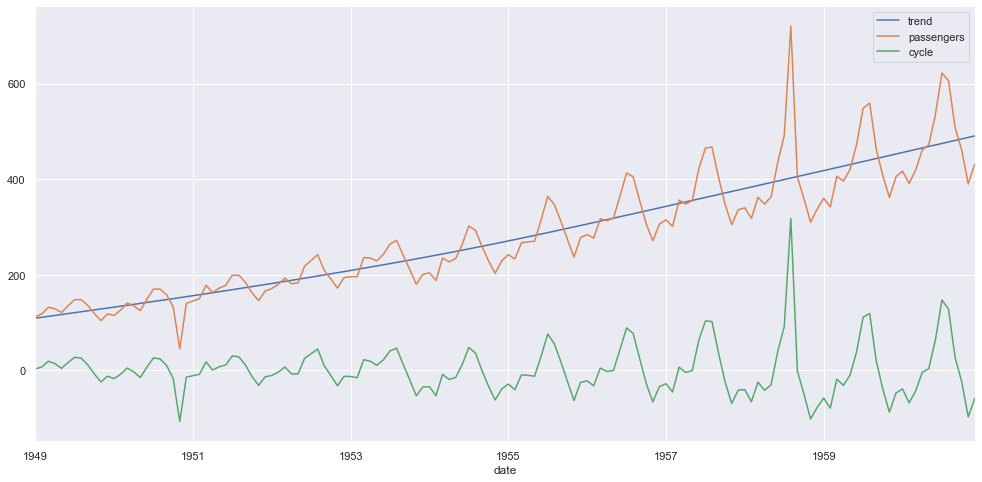

In [47]:
from statsmodels.tsa.filters.hp_filter import hpfilter

pass_cycle, pass_trend = hpfilter(y['passengers'], lamb = 129600)

y['trend'] = pass_trend
y['cycle'] = pass_cycle

y[['trend','passengers','cycle']].plot(figsize = (15, 8)).autoscale(axis = 'x', tight = True);

Veamos la fuerza de la tendencia:

In [48]:
max(0, (1 - decomposition.resid.var() / (decomposition.resid + decomposition.trend).var()))

0.9999994659608745

Antes de pasar a la parte de modelado, primero asegurémonos de que nuestra data pueda ajustarse al modelo ARIMA, que es el algoritmo seleccionado para este proyecto.

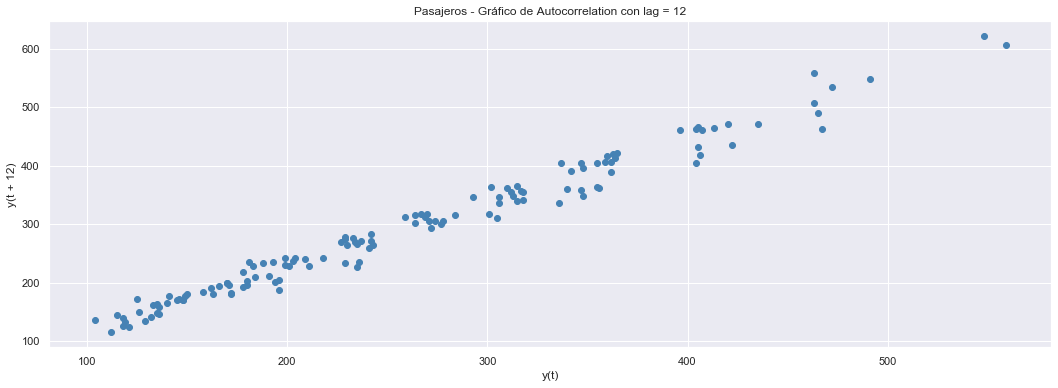

In [49]:
plt.figure(figsize = (16, 6))

pd.plotting.lag_plot(df['passengers_clean'], lag = 12, c = ['steelblue'][0])
plt.title('Pasajeros - Gráfico de Autocorrelation con lag = 12');

Podemos apreciar que hay una clara y fuerte correlación en nuestros datos y, por lo tanto, ARIMA va a ser un buen modelo para usar.

# Modelos

Se empezará por dividir la serie para separar la parte de entrenamiento y la parte de prueba.

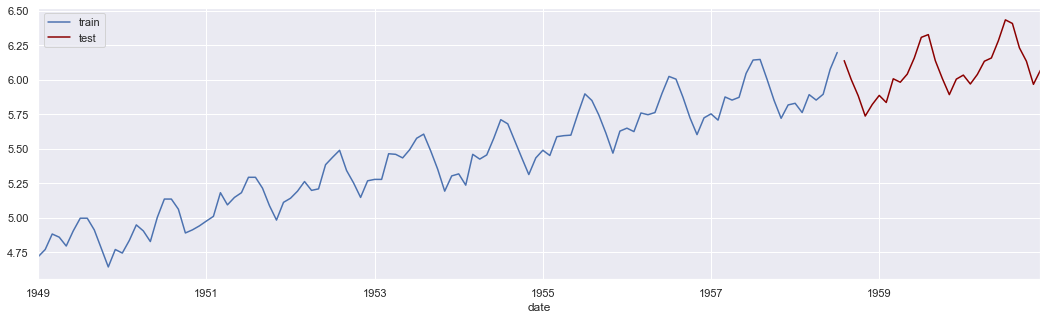

In [50]:
train = df_log[:int(0.80 * (len(df_log)))]
test = df_log[int(0.80 * (len(df_log))):]
train.index = pd.DatetimeIndex(train.index, freq = 'MS')
test.index = pd.DatetimeIndex(test.index, freq = 'MS')

train['passengers_clean'].plot(label = 'train')
test['passengers_clean'].plot(label ='test', color = 'darkred')
plt.legend();

Antes de hacer el modelo se crean las funciones que calcularán y mostrarán las métricas de evaluación.

In [51]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y, pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index = [0])
    
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    
    return results

<p style="color:darkred; font-weight:bold; font-family:newtimesroman; font-size:150%; text-align:left">Modelo base</p>

Siempre es recomendable elaborar un primer modelo con los parámetros por defecto, el cual será la base a partir del cual se empezará a mejorar la métrica de evaluación elegida.

In [52]:
model_1 = auto_arima(train, trace = True, error_action = 'ignore', suppress_warnings = True)
model_1.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-216.941, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-196.140, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-197.808, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-199.472, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-196.262, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-222.912, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-198.030, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-223.447, Time=0.41 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-205.290, Time=0.12 s

ARIMA(order=(5, 1, 3), scoring_args={}, suppress_warnings=True)

In [53]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(5, 1, 3)   Log Likelihood                 124.357
Date:                Tue, 18 Jul 2023   AIC                           -228.714
Time:                        17:30:41   BIC                           -201.352
Sample:                             0   HQIC                          -217.609
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0150      0.003      5.356      0.000       0.009       0.020
ar.L1         -0.1681      0.181     -0.930      0.353      -0.522       0.186
ar.L2         -0.0539      0.164     -0.329      0.742      -0.375       0.267
ar.L3          0.3863      0.138      2.802      0.005       0.116       0.657
ar.L4         -0.2776      0.115     -2.414      0.016      -0.503      -0.052
ar.L5         -0.2633      0.115     -2.295      0.022      -0.488      -0.038
ma.L1          0.1226      0.210      0.584      0.559      -0.289       0.534
ma.L2         -0.3405      0.205     -1.659      0.097      -0.743       0.062
ma.L3         -0.7388      0.228     -3.244      0.001      -1.185      -0.292
sigma2         0.0064      0.002      4.017      0.000       0.003       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.73
Prob(Q):                              0.93   Prob(JB):                         0.03
Heteroskedasticity (H):               1.21   Skew:                            -0.02
Prob(H) (two-sided):                  0.56   Kurtosis:                         1.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se genera el pronóstico.

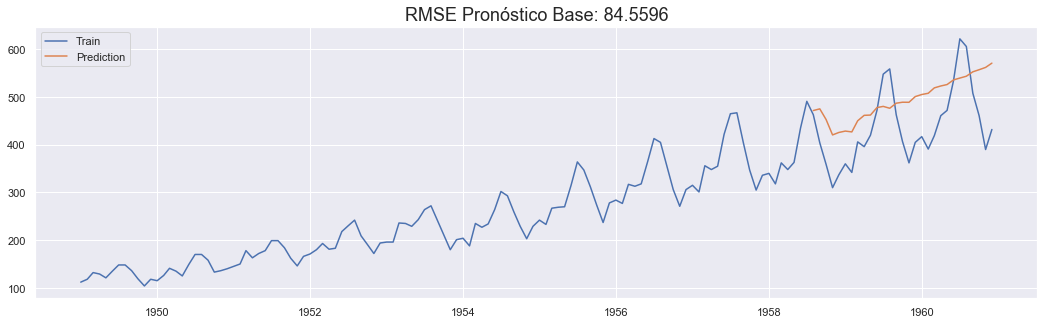

In [54]:
forecast_1 = model_1.predict(n_periods = len(test))
forecast_1 = pd.DataFrame(np.exp(forecast_1), index = test.index, columns = ['Prediction'])
rmse = mean_squared_error(np.exp(test.passengers_clean), forecast_1.Prediction, squared = False)

plt.plot(df.passengers_clean, label = 'Train')
plt.plot(forecast_1, label = 'Prediction')
plt.title('RMSE Pronóstico Base: %.4f'%rmse, fontsize = 18)
plt.legend();

Evaluación

In [55]:
res_1 = evaluate_forecast(np.exp(test.passengers_clean), forecast_1.Prediction).T.rename(columns = {0:'value'})
res_1

,value
r2_score,-0.196538
mean_absolute_error,75.308533
median_absolute_error,82.152173
mse,7150.326088
mape,18.322699
rmse,84.559601


Se revisan los residuales.

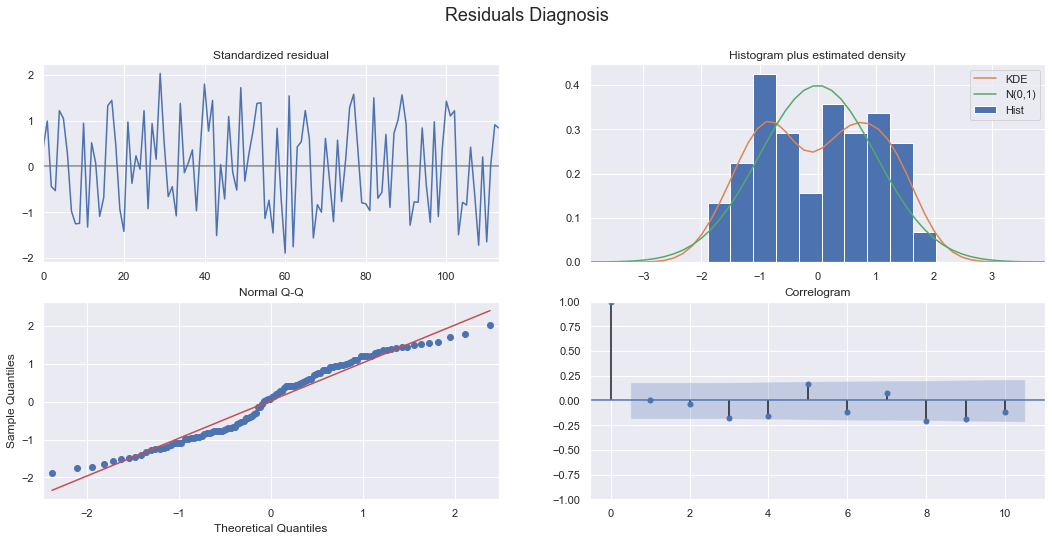

In [56]:
model_1.plot_diagnostics(figsize = (16, 8))
plt.suptitle('Residuals Diagnosis', size = 18);

<p style="color:darkred; font-weight:bold; font-family:newtimesroman; font-size:150%; text-align:left">Modelo 2</p>

Como era de esperarse este primer modelo tiene un mal desempeño, ya que captura la tendencia pero no la estacionalidad. Por lo que, se creará un segundo modelo, pero esta vez calibrando algunos de sus hiperparámetros.

In [57]:
model_2 = auto_arima(train,
                    trace = True,
                    error_action = 'ignore',
                    suppress_warnings = True,
                   m = 12,
                   max_order = None,
                   max_p = 7,
                   max_d = 1,
                   max_q = 7,
                   max_P = 4,
                   max_D = 1,
                   max_Q = 4,
                   maxiter = 50,
                   alpha = 0.05,
                   n_jobs= -1,
                   trend = 'ct',
                   information_criterion = 'oob',
                   out_of_sample_size = int(len(df) * 0.2))


model_2.fit(train)

Performing stepwise search to minimize oob
 ARIMA(2,0,2)(1,1,1)[12] intercept   : OOB=0.009, Time=1.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : OOB=0.004, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : OOB=0.002, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : OOB=0.002, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[12]             : OOB=0.004, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : OOB=0.006, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : OOB=0.002, Time=1.80 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : OOB=0.005, Time=1.11 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : OOB=0.002, Time=0.79 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : OOB=0.003, Time=1.89 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : OOB=0.022, Time=0.51 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : OOB=0.002, Time=0.78 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : OOB=0.004, Time=0.89 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : OOB=0.023, Time=0.62 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : OOB=0.003, Time=0.99 s

ARIMA(order=(1, 0, 0), out_of_sample_size=28, scoring_args={},
      seasonal_order=(1, 1, 0, 12), suppress_warnings=True, trend='ct',
      with_intercept=False)

In [58]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 181.580
Date:                            Tue, 18 Jul 2023   AIC                           -353.161
Time:                                    17:32:12   BIC                           -339.987
Sample:                                         0   HQIC                          -347.825
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0899      0.021      4.308      0.000       0.049       0.131
drift         -0.0002      0.000     -1.409      0.159      -0.001    9.57e-05
ar.L1          0.6126      0.084      7.301      0.000       0.448       0.777
ar.S.L12      -0.5070      0.089     -5.714      0.000      -0.681      -0.333
sigma2         0.0017      0.000      7.925      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.95   Jarque-Bera (JB):                 5.56
Prob(Q):                              0.16   Prob(JB):                         0.06
Heteroskedasticity (H):               0.33   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se genera el pronóstico

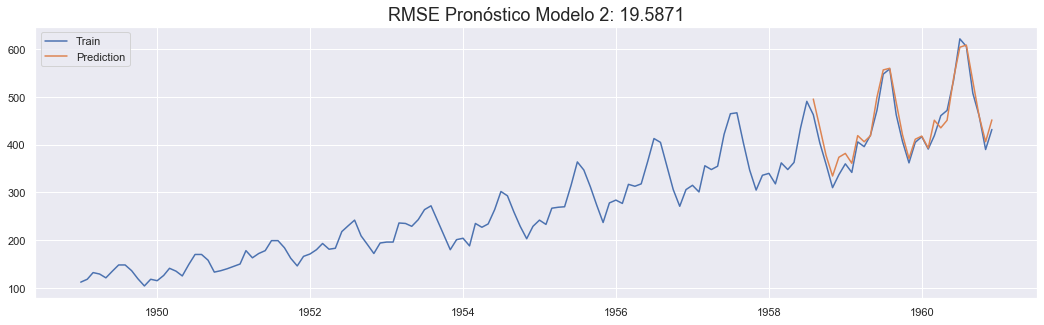

In [59]:
forecast_2 = model_2.predict(n_periods = len(test))
forecast_2 = pd.DataFrame(np.exp(forecast_2), index = test.index, columns = ['Prediction'])
rmse2 = mean_squared_error(np.exp(test.passengers_clean), forecast_2.Prediction, squared = False)

plt.plot(df.passengers_clean, label = 'Train')
plt.plot(forecast_2, label = 'Prediction')
plt.title('RMSE Pronóstico Modelo 2: %.4f'%rmse2, fontsize = 18)
plt.legend();

Evaluación

In [60]:
res_2 = evaluate_forecast(np.exp(test.passengers_clean), forecast_2.Prediction).T.rename(columns = {0:'value'})
res_2

,value
r2_score,0.935799
mean_absolute_error,16.292525
median_absolute_error,17.519997
mse,383.653848
mape,3.936830
rmse,19.587084


Diagnosis

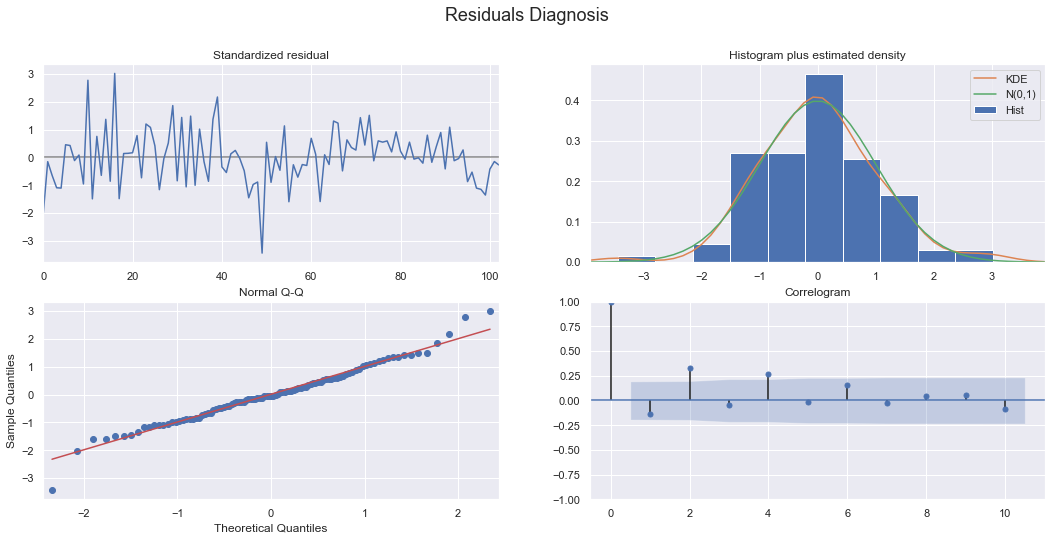

In [61]:
model_2.plot_diagnostics(figsize = (16, 8))
plt.suptitle('Residuals Diagnosis', size = 18);

<p style="color:darkred; font-weight:bold; font-family:newtimesroman; font-size:150%; text-align:left">Modelo 3</p>

El modelo 2 mejoró considerablemente la métrica de evaluación. Sin embargo, se generará otro modelo para ver si se puede mejorar aún más dicha métrica.

In [62]:
model_3 = auto_arima(train,
                   trace = True,
                   error_action = 'ignore', 
                   suppress_warnings = True, 
                   seasonal = True,
                   m = 12,
                   trend = 'ct',
                   stepwise = True)

model_3.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-327.831, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-272.887, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-353.426, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-324.561, Time=0.73 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-272.887, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-329.699, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-277.962, Time=1.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-318.096, Time=0.58 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-332.799, Time=0.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-299.912, Time=1.44 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-196.921, Time=0.41 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-254.083, Time=0.85 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-349.266, Time=0.76 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-217.974, Time=0.58 sec
 ARIMA(2,0,1)(1,1,0

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, trend='ct')

In [63]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 181.713
Date:                            Tue, 18 Jul 2023   AIC                           -353.426
Time:                                    17:33:00   BIC                           -340.252
Sample:                                         0   HQIC                          -348.090
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0923      0.021      4.442      0.000       0.052       0.133
drift         -0.0003      0.000     -1.722      0.085      -0.001    4.14e-05
ar.L1          0.6204      0.082      7.546      0.000       0.459       0.782
ar.S.L12      -0.4994      0.088     -5.653      0.000      -0.673      -0.326
sigma2         0.0017      0.000      7.910      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   2.40   Jarque-Bera (JB):                 4.90
Prob(Q):                              0.12   Prob(JB):                         0.09
Heteroskedasticity (H):               0.31   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se genera el pronóstico

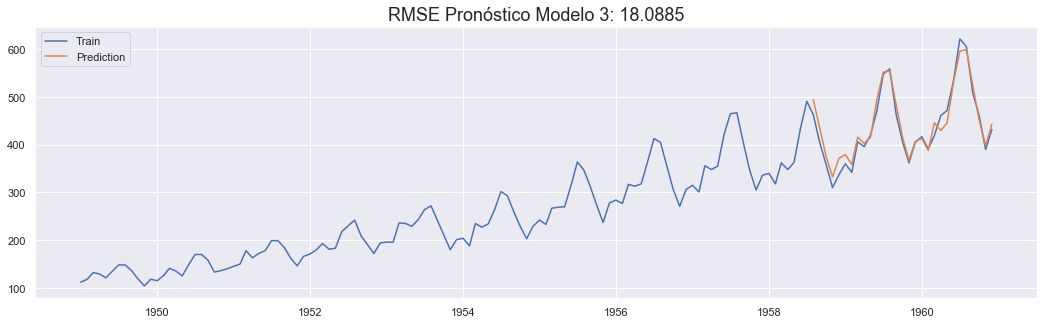

In [64]:
forecast_3 = model_3.predict(n_periods = len(test))
forecast_3 = pd.DataFrame(np.exp(forecast_3), index = test.index, columns = ['Prediction'])
rmse3 = mean_squared_error(np.exp(test.passengers_clean), forecast_3.Prediction, squared = False)

plt.plot(df.passengers_clean, label = 'Train')
plt.plot(forecast_3, label = 'Prediction')
plt.title('RMSE Pronóstico Modelo 3: %.4f'%rmse3, fontsize = 18)
plt.legend();

Evaluación

In [65]:
res_3 = evaluate_forecast(np.exp(test.passengers_clean), forecast_3.Prediction).T.rename(columns = {0:'value'})
res_3

,value
r2_score,0.945247
mean_absolute_error,14.913586
median_absolute_error,11.352533
mse,327.194256
mape,3.554629
rmse,18.088512


Diagnosis

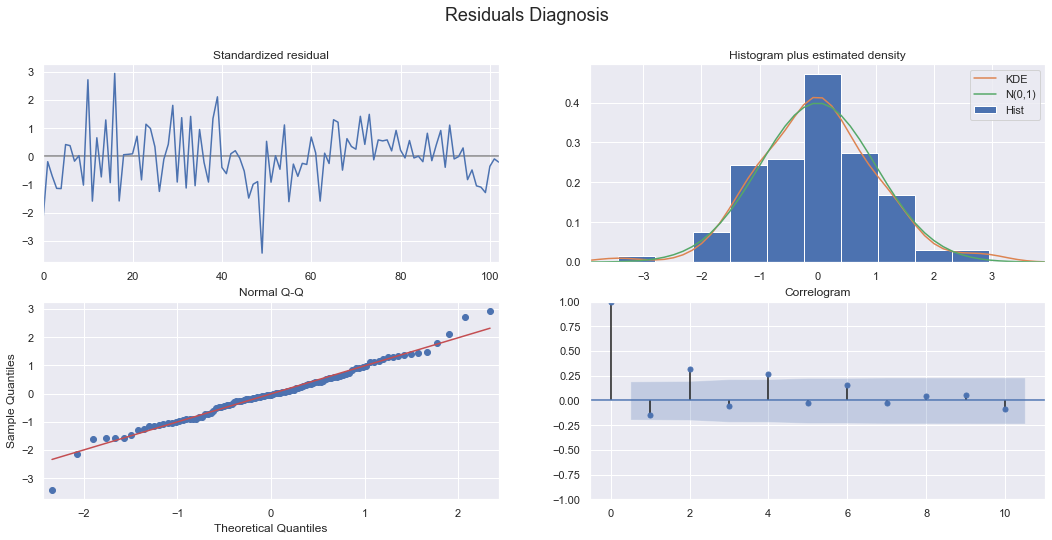

In [66]:
model_3.plot_diagnostics(figsize = (16, 8))
plt.suptitle('Residuals Diagnosis', size = 18);

<p style="color:darkred; font-weight:bold; font-family:newtimesroman; font-size:150%; text-align:left">Modelo 4</p>

Hasta aquí el mejor modelo es el número 3, un modelo **SARIMA**. Ahora vamos a usar otra metodología para ver si podemos mejorar los pronósticos.

Se establecen los argumentos del modelo. Para los ordenes de integración se topan al 1, ya que es suficiente para hacer la serie estacionaria. Los componentes AR y MA, se topan hasta el 2, porque los dos modelos anteriores no necesitaron más y sus resultados fueron buenos.

In [67]:
p = q = range(0, 3)
d = range(0, 2)
 
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Ejemplos de combinación de parámetros para un modelo estacional ARIMA (SARIMA):')
print('\nSARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Ejemplos de combinación de parámetros para un modelo estacional ARIMA (SARIMA):

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


Vamos a crear una clase que genere los modelos para todas las combinaciones de argumentos anteriormente diseñados. Además, con esta clase se puede usar con cualquier base de datos.

In [68]:
import pandas as pd
import warnings
import itertools

class mySarima:
    
    def __init__(self, regular_pdq, seasonal_pdq, data):
        
        self.regular_pdq = regular_pdq
        self.seasonal_pdq = seasonal_pdq
        self.data = data

class myModels(mySarima):
    
    def fit(self):
        
        models = []
        
        
        for i in self.regular_pdq:
            for j in self.seasonal_pdq:
                
                mod = sm.tsa.statespace.SARIMAX(self.data,
                                                order = i,
                                                seasonal_order = j,
                                                trend = 't',
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)

                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')
                    results = mod.fit()

                print('ARIMA{}x{}12 - AIC:{}'.format(i, j, results.aic))
                
                models.append(results)
    
        aics = []

        for x in range(0, len(models)):
                aics.append(models[x].aic)
                min_aic = min(aics)

                if min_aic == models[x].aic:
                    best_model = models[x]

        return best_model

Se instancia o crea el objeto con los argumentos que se necesitan.

In [69]:
mis_sarimas = myModels(regular_pdq = pdq, seasonal_pdq = seasonal_pdq, data = train)

Se generan todos los modelos y se almacena el que tenga el menor AIC, que es el criterio de selección elegido.

In [70]:
my_model = mis_sarimas.fit()

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:525.8458681769041
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:352.97115573259725
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:325.62154344391735
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-193.94065013211633
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-182.6168048131809
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:-178.93982721142663
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-270.268862145348
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-303.8324399365115
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:-250.85481790627244
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-167.4407945070937
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-212.37469828480468
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:-197.16001709735983
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:-264.47001254760147
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:-265.91588827816497
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:-198.29022221042686
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:-187.8721068060889
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:-197.15026557990817
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:-181

ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:-177.49024735886948
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:-182.34916532019406
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:-319.7908837678477
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:-316.52145712254594
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:-226.20549573199366
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:-323.2996462146495
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:-310.7791115857705
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:-273.7594550151287
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:-243.15545273979274
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:-258.68227383005154
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:-235.81218930570256
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:-318.40023784206335
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:-318.8975195515266
ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:-315.5275310309829
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:-232.28393108733152
ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:-242.57536025411764
ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:-199.0916181388116
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-

ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:-323.47154806773113
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:-99.89309912038466
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:-62.84222337591292
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:-306.809809327309
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:-327.16917306620593
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:-257.7521865982457
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:-177.55334077769314
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:-310.4377291827657
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:-105.46018923628316
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:-270.61588083924545
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:-267.27393214922955
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:-280.58938043935177
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:-62.027124953040044
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:-145.19961332695138
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:-108.73586256621807
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:-194.765023787493
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:-221.05195587637417
ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:-2

In [71]:
my_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   passengers_clean   No. Observations:                  115
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 186.899
Date:                            Tue, 18 Jul 2023   AIC                           -361.798
Time:                                    17:42:34   BIC                           -346.107
Sample:                                01-01-1949   HQIC                          -355.446
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0002      0.000     -1.647      0.100      -0.000    3.98e-05
ar.L1          0.8316      0.110      7.550      0.000       0.616       1.048
ma.L1         -0.3836      0.185     -2.077      0.038      -0.746      -0.022
ar.S.L12       1.0382      0.006    184.811      0.000       1.027       1.049
ma.S.L12      -0.5826      0.162     -3.599      0.000      -0.900      -0.265
sigma2         0.0015      0.000      7.953      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                18.77
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se genera el pronóstico.

In [72]:
start_index = test.index.min()
end_index = test.index.max()

pred = my_model.get_prediction(start = start_index, end = end_index, dynamic = False)

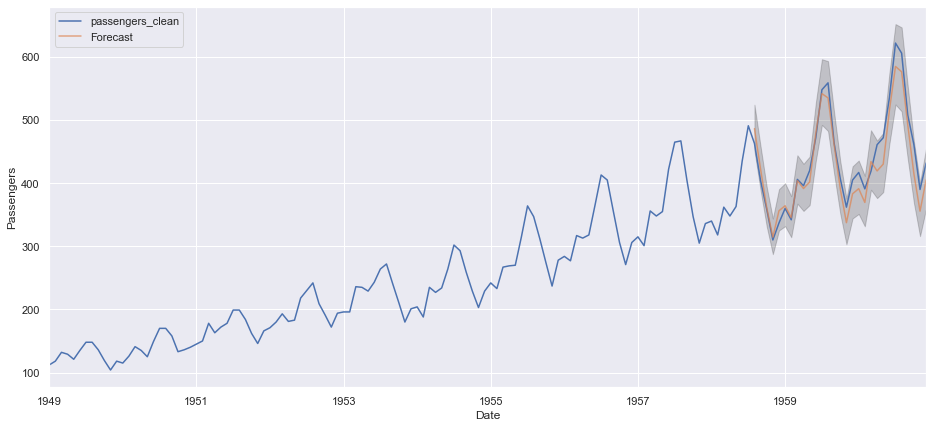

In [73]:
pred_ci = np.exp(pred.conf_int())

ax = df['1949':].plot(label = 'observed')
np.exp(pred.predicted_mean).plot(ax = ax, label = 'Forecast', alpha = 0.7, figsize = (14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend(loc = 'upper left');

Evaluación.

In [74]:
forecast_4 = np.exp(pred.predicted_mean.values)
y_truth = df[start_index:end_index].passengers_clean.values

res_4 = evaluate_forecast(y_truth, forecast_4).T.rename(columns = {0:'value'})
res_4

,value
r2_score,0.911215
mean_absolute_error,19.191467
median_absolute_error,19.291236
mse,530.567162
mape,4.300994
rmse,23.034044


Diagnosis.

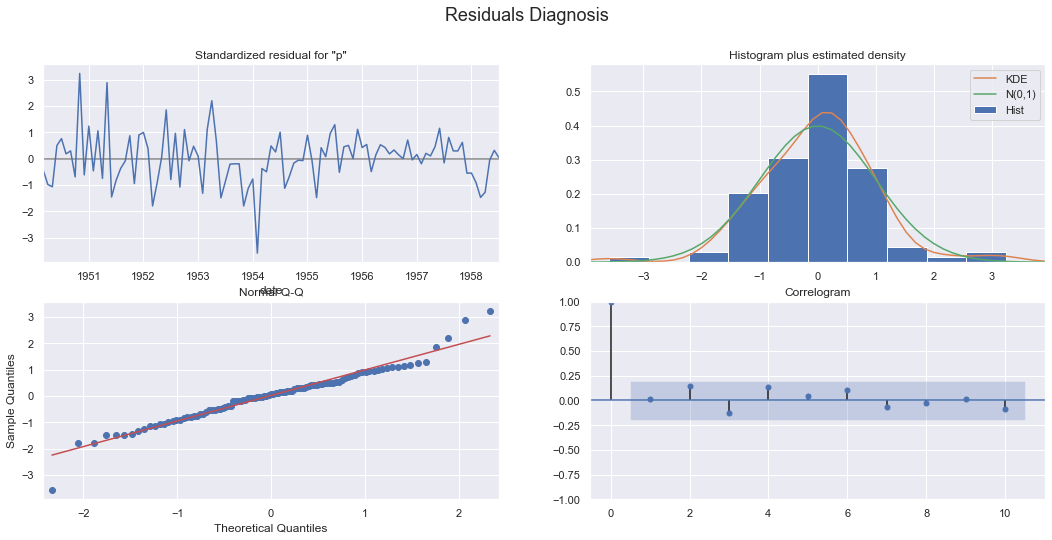

In [75]:
my_model.plot_diagnostics(figsize = (16, 8))
plt.suptitle('Residuals Diagnosis', size = 18);

Este último modelo tuvo buenos resultados, sin embargo, no mejoró la métrica de evaluación de los modelos 2 y 3.

Finalmente, se comparan las métricas de evaluación, para tener una visión más rápida de todos los modelos juntos.

In [76]:
cols = ['modelo_1', 'modelo_2', 'modelo_3', 'modelo_4']
final = pd.concat(objs = [res_1, res_2, res_3, res_4], axis = 1)
final.columns = cols
final

,modelo_1,modelo_2,modelo_3,modelo_4
r2_score,-0.196538,0.935799,0.945247,0.911215
mean_absolute_error,75.308533,16.292525,14.913586,19.191467
median_absolute_error,82.152173,17.519997,11.352533,19.291236
mse,7150.326088,383.653848,327.194256,530.567162
mape,18.322699,3.936830,3.554629,4.300994
rmse,84.559601,19.587084,18.088512,23.034044


El mejor modelo es el modelo_3 con la forma: **ARIMA(1,0,0)(1,1,0)[12]** con un `mape = 3.5546`

# Validación supuestos

<div clas=text-justify>
Finalmente, lo que se debe de hacer antes de dar por bueno un pronóstico de serie de tiempo es validar los supuestos de <strong>normalidad</strong>, <strong>heterocedasticidad</strong> y <strong>autocorrelación</strong> a los residuales. Aunque en la realidad a veces se relajan dichos supuestos mientras el modelo final tenga buen poder predictivo. Para este proyecto se van a validar con el fin de mostrar el procedimiento y conocer la validez teórica del modelo.
</div>

## Normalidad

Este supuesto consiste en que la serie a analizar presenta una distribución normal. Para validar este supuesto, se consideran los test de **Shapiro** y **D’Agostino’s**:

Las pruebas consideran las siguientes hipótesis:

H0: La distribución es normal

H1: La distribución no es normal

Por lo que, si el p-valor es mayor al nivel de significancia elegido (que será el 0.05) no se rechaza la hipótesis nula y, por lo tanto, podemos suponer que la distribución en cuestión se distribuye como una normal.

Se crea una función que nos muestre el resultado y la interpretación de las pruebas.

In [77]:
from scipy import stats

def errores_test(y_true, y_pred, alpha = 0.05):
    result = y_true - y_pred
    result = result.to_numpy()
    
    k2, p = stats.shapiro(result) # Shapiro Test
    k2d, pd = stats.normaltest(result) # D’Agostino’s K^2 Test
    alpha = alpha
    
    print("Shapiro Test: \n")
    print("p-value = {:g}".format(p))
    
    if p > alpha: # null hypothesis: x viene de una distribucion normal
        print("No se puede rechazar la hipótesis nula (Normal)\n")
    else:
        print("La hipótesis nula puede ser rechazada (No Normal)\n")
    
    print("D’Agostino’s K^2 Test: \n")
    print("p-value = {:g}".format(pd))
    
    if pd > alpha: # null hypothesis: x viene de una distribucion normal
        print("No se puede rechazar la hipótesis nula (Normal)")
    else:
        print("La hipótesis nula puede ser rechazada (No Normal)")

In [78]:
errores_test(np.exp(test.passengers_clean), forecast_3.Prediction)

Shapiro Test: 

p-value = 0.324371
No se puede rechazar la hipótesis nula (Normal)

D’Agostino’s K^2 Test: 

p-value = 0.469371
No se puede rechazar la hipótesis nula (Normal)


Los residuales del modelo final (modelo 3) pasan las pruebas de normalidad. Lo anterior, se sospechaba al ver su histograma.

## Heterocedasticidad

Este supuesto se refiere a que la varianza de la serie en cuestión es constante a lo largo del tiempo, o sea, debe de ser homocedastica.

Para validar este supuesto se aplicará la prueba **White** y **Breusch-Pagan**.

* **H0**: (Hipótesis Nula): Homocedasticidad está presente (los residuos se distribuyen con igual varianza)

* **H1**: (Hipótesis Alterna): Hay heterocedasticidad (los residuos no se distribuyen con igual varianza)

Si el p-valor de los resultados de la prueba es menor que alfa (nivel de significación = 0.05), entonces podemos rechazar H0 y concluir que los datos son heteroscedásticos.

Se prepara la data agregando una columna de numeración consecutiva a los residuales que funcionará como la variable independiente en la regresión auxiliar.

In [79]:
temp = np.exp(test.passengers_clean) - forecast_3.Prediction
temp = temp.to_frame().rename(columns = {0:'residuales'})

temp['Time_Period'] = range(1, len(temp) + 1)
temp.head(10)

,residuales,Time_Period
date,,
1958-08-01,-31.496343,1
1958-09-01,-30.423480,2
1958-10-01,-16.735238,3
1958-11-01,-22.471354,4
1958-12-01,-34.362766,5
1959-01-01,-19.257701,6
1959-02-01,-16.568478,7
1959-03-01,-9.948968,8
1959-04-01,-7.033115,9


Se ajusta un modelo de regresión lineal OLS al conjunto de datos creado.

In [80]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

expr = 'residuales ~ Time_Period'

olsr_results = smf.ols(expr, temp).fit()

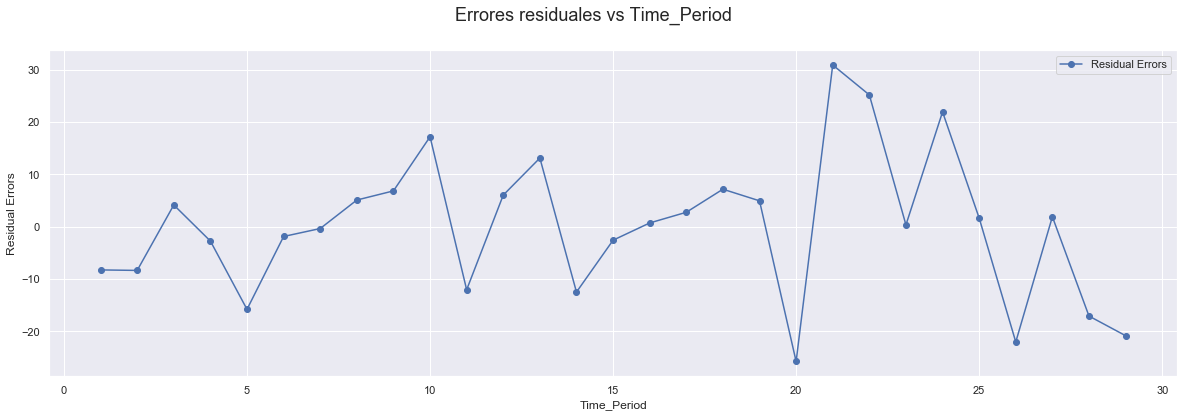

In [81]:
fig = plt.figure(figsize = (18, 6))
 
plt.plot(temp['Time_Period'], olsr_results.resid, 'bo-', label = 'Residual Errors')
fig.suptitle('Errores residuales vs Time_Period', size = 18)
plt.xlabel('Time_Period')
plt.ylabel('Residual Errors')
plt.legend(loc = 'best');

En la grafica anterior, no se aprecia una tendencia en los residuales, lo que es buena señal.

In [82]:
temp['SQ_RESID'] = np.power(olsr_results.resid, 2.0)
temp['SQ_Time_Period'] = np.power(temp['Time_Period'], 2.0)

# se construye la expresión del modelo (en sintaxis patsy) para el modelo auxiliar:
aux_expr = 'SQ_RESID ~ Time_Period + SQ_Time_Period'

# se crean las matrices X e Y.
y, X = dmatrices(aux_expr, temp, return_type = 'dataframe')

# se agrega una columna a X para guardar la intersección de regresión:
X = sm.add_constant(X)

# se crea y entrena un modelo OLSR en el conjunto de datos (y, X):
aux_olsr_results = sm.OLS(y, X).fit()

print(aux_olsr_results.summary())

                            OLS Regression Results                            
Dep. Variable:               SQ_RESID   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     2.924
Date:                Tue, 18 Jul 2023   Prob (F-statistic):             0.0715
Time:                        17:44:05   Log-Likelihood:                -197.92
No. Observations:                  29   AIC:                             401.8
Df Residuals:                      26   BIC:                             405.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.5091    140.620      0.

Los p-valores de las regresoras **no son significativos**, por lo que, es buena señal, porque significa que no estan correlacionados con el cuadrado de los residuales.

Otro test para validar que los residuales presentan varianza constante es la prueba **Breusch-Pagan**. Igualmente, lo que se busca es que el p-valor sea mayor al nivel de significancia.

In [83]:
def test_model(col):
    s = []
    for i in col:
        a = [1, i]
        s.append(a)
    return (np.array(s))

resid_model = test_model(temp['residuales'])

In [84]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(aux_olsr_results.resid, resid_model)

print ('LM-test p_value: {}'.format(round(bp_test[1],6)))

LM-test p_value: 0.004224


Como el p-valor es menor al nivel de significancia más usado que es del 0.05, se rechaza la hipótesisis de homocedasticidad. Esto era de esperarse ya que la gráfica de la serie original presenta tendencia creciente multiplicativa y aplicando logaritmos se pudo suavizar su forma pero no fue suficiente.

## Autocorrelación

Este otro supuesto significa que los errores dependen de si mismos pero en periodos pasados, en otras palabras, los errores están correlacionados entre sí.

Este supuesto se evaluará con la clásica prueba de **Durbin-Watson**

H0 (hipótesis nula): No existe correlación entre los residuos.

H1 (hipótesis alterna): Los residuos están autocorrelacionados.

El estadístico de prueba siempre estará entre 0 y 4 con la siguiente interpretación:

* Una estadística de prueba de 2 indica que no hay correlación serial.
* Cuanto más cerca de 0 estén las estadísticas de la prueba, más evidencia de correlación serial positiva.
* Cuanto más cerca estén las estadísticas de la prueba de 4, más evidencia de correlación serial negativa.

Como regla general, los valores estadísticos de prueba entre el rango de 1.5 y 2.5 se consideran normales. Sin embargo, los valores fuera de este rango podrían indicar que la autocorrelación es un problema.

In [85]:
from statsmodels.stats.stattools import durbin_watson

round(durbin_watson(aux_olsr_results.resid),4)

1.5936

El estadístico de prueba es 1.59 . Dado que esto está dentro del rango de 1.5 y 2.5, consideraríamos que la autocorrelación no es un problema.

# Ensamble

Una estratégia alternativa cuando se tienen varios modelos que presentan diferencias en sus pronósticos es hacer un ensamble, o sea, considerar los respectivos pronósticos para hacer uno solo, en otras palabras, se puede calcular el promedio simple o ponderado.

En esta última parte se optará por seguir esa estratégia para ver si podemos mejorar los resultados. 

Se genera el dataset con los pronósticos de los modelos creados (excepto las del modelo base).

In [86]:
ensemble = pd.concat(objs = [forecast_2.Prediction,
                             forecast_3.Prediction,
                             pd.DataFrame(forecast_4, index = forecast_2.index)], axis = 1)

ensemble.columns = ['Prediction_2','Prediction_3','Prediction_4']
ensemble.head()

,Prediction_2,Prediction_3,Prediction_4
date,,,
1958-08-01,495.737538,494.496343,486.481007
1958-09-01,436.249179,434.423480,422.177644
1958-10-01,377.686059,375.735238,361.482218
1958-11-01,334.417626,332.471354,314.506003
1958-12-01,373.756319,371.362766,356.291236


Se calcula el promedio simple de las predicciones.

In [87]:
ensemble['Prediction_avg'] =  ensemble.mean(axis = 1)
ensemble.head()

,Prediction_2,Prediction_3,Prediction_4,Prediction_avg
date,,,,
1958-08-01,495.737538,494.496343,486.481007,492.238296
1958-09-01,436.249179,434.423480,422.177644,430.950101
1958-10-01,377.686059,375.735238,361.482218,371.634505
1958-11-01,334.417626,332.471354,314.506003,327.131661
1958-12-01,373.756319,371.362766,356.291236,367.136774


Se generan las métricas de error

In [88]:
res_5 = evaluate_forecast(y_truth, ensemble.Prediction_avg).T.rename(columns = {0:'ensemble'})
res_5

,ensemble
r2_score,0.952702
mean_absolute_error,13.752274
median_absolute_error,11.008001
mse,282.644533
mape,3.214750
rmse,16.812035


Sí mejoraron los errores con respecto al mejor modelo (modelo_3)

In [89]:
pd.concat(objs = [final[['modelo_3']], res_5], axis = 1)

,modelo_3,ensemble
r2_score,0.945247,0.952702
mean_absolute_error,14.913586,13.752274
median_absolute_error,11.352533,11.008001
mse,327.194256,282.644533
mape,3.554629,3.214750
rmse,18.088512,16.812035


Se grafica el pronóstico versus la serie original para ver su ajuste.

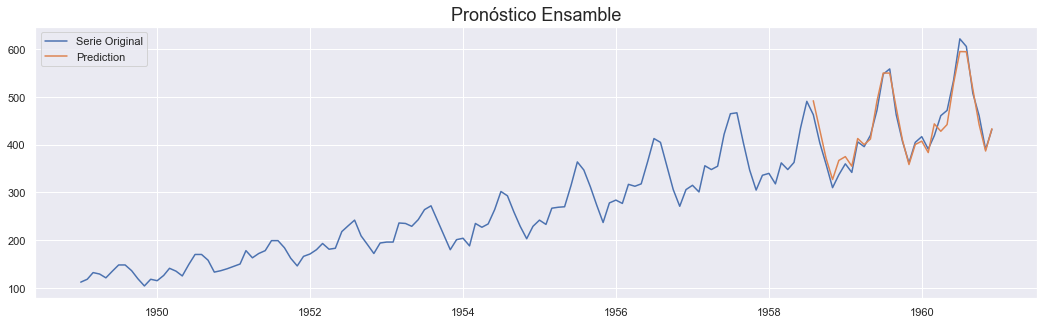

In [90]:
plt.plot(df.passengers_clean, label = 'Serie Original')
plt.plot(ensemble.Prediction_avg, label = 'Prediction')
plt.title('Pronóstico Ensamble', fontsize = 18)
plt.legend();

In [91]:
final = pd.concat(objs = [final, res_5], axis = 1)
final

,modelo_1,modelo_2,modelo_3,modelo_4,ensemble
r2_score,-0.196538,0.935799,0.945247,0.911215,0.952702
mean_absolute_error,75.308533,16.292525,14.913586,19.191467,13.752274
median_absolute_error,82.152173,17.519997,11.352533,19.291236,11.008001
mse,7150.326088,383.653848,327.194256,530.567162,282.644533
mape,18.322699,3.936830,3.554629,4.300994,3.214750
rmse,84.559601,19.587084,18.088512,23.034044,16.812035


<div class=text-justify>
Con esta técnica se pudo mejorar el pronóstico al obtener un mape de <strong>3.2147</strong>. Como se mencionó anteriormente, esta técnica se recomienda cuando los modelos generados tienen diferencias en sus resultados y con el ensamble se compensan unos con otros. Sin embargo, aquí se realizó esta estratégia con fines ilustrativos, pues la reducción de los errores es muy poca.
</div>

Ya teniendo el modelo final o la estratégia de ensamble final, se vuelve a hacer el entrenamiento con todo el conjunto de datos y ya solo se generan las predicciones para el périodo requerido.

# Conclusiones

Este fue un proyecto en el que se trabajo una serie de tiempo mensual, la cual sirvió para practicar técnicas comunes de análisis de datos como la imputación de datos faltantes así como la detección y corrección de datos atípicos.

<div class=text-justify>
Como se pudo ver a lo largo de este proyecto, hay varias estratégias para conseguir un buen pronóstico con la misma familia de modelos <strong>ARIMA</strong>. Sin embargo, hay más algoritmos que se pueden utilizar para modelar series de tiempo como con el paquete <strong>prophet</strong>, algunas redes neuronales <strong>LSTM</strong> y <strong>RNN</strong> incluso con un <strong>Gaussian Process</strong>.
</div>
<br>
Todo dependerá de los datos que se tengan.

In [92]:
import session_info

session_info.show(html = False)

-----
ipykernel           5.1.4
matplotlib          3.1.3
numpy               1.21.6
pandas              1.3.5
patsy               0.5.2
pmdarima            1.8.5
scipy               1.4.1
seaborn             0.11.2
session_info        1.0.0
sklearn             1.0.2
statsmodels         0.13.2
-----
IPython             7.12.0
jupyter_client      7.3.4
jupyter_core        4.10.0
jupyterlab          1.2.6
notebook            6.0.3
-----
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.18362-SP0
-----
Session information updated at 2023-07-18 17:45
